# Class 05 선형회귀<sup>Linear Regression</sup>

- 주요 참고 문헌 :  Pattern Recognition and Machine Learning, Christopher Bishop, Springer<sup>[Bishop]</sup>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# matplotlib style
style_name = 'bmh' #bmh
mpl.style.use(style_name)
style = plt.style.library[style_name]
style_colors = [ c['color'] for c in style['axes.prop_cycle'] ]

np.set_printoptions(precision=4, linewidth =150)

##########################################################
# for sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

##########################################################
# for plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from IPython.core.display import display, HTML

init_notebook_mode(connected=True)

# https://github.com/plotly/plotly.py/issues/515
# The polling here is to ensure that plotly.js has already been loaded before
# setting display alignment in order to avoid a race condition.
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 사전작업

- 4주차 만들었던 `minimize()` 함수를 불러 온다.

- 이 노트북에서 실행되는 모든 실험은 기본적으로 `scipy.optimize.minimize()`를 이용하지만 주석처리된 부분을 바꿔주면 직접 코딩한 최적화 함수 `minimize()`를 이용해서도 동일한 결과를 만들 수 있다.

In [2]:
import sys
sys.path.append('../../class-04/notebook')

# 함수 임포트
try:
    print("try import optimize_ans")
    from optimize_ans import minimize
except ImportError:
    print("import optimize")
    from optimize import minimize
    

try import optimize_ans


## 목표

- 주어진 데이터를 대표하는 곡선을 찾기 위해 최소제곱법을 구성한다.

- 구성된 최소제곱법을 풀어내기 위해 `scipy.optimize.minimize()`와 직접 코딩한 `minimize()`를 적용한다.

- 모델의 복잡도가 문제를 변화시키는 양상과 규제화<sup>regularization</sup>의 메커니즘을 이해한다.

- 볼록계획<sup>convex programming problem</sup>문제인 선형회귀를 해석적으로 풀기 위한 과정인 정규방정식을 이해한다.


## 데이터 생성

- 실험용 데이터를 생성하기 위해곡선 $\sin(2\pi x)$에 적당한 노이즈를 더하여 데이터를 생성


- $\boldsymbol{\mathsf{x}}_{\text{train}} = (x_1, x_2, \dots, x_N)^{\text{T}}$ : 
[0,1]구간을 등간격으로 잘라 만든 $x$ 값 입력 데이터로 $N=10$으로 데이터 10개를 생성

- $\boldsymbol{\mathsf{t}}_{\text{train}} = (t_1, t_2, \dots, t_N)^{\text{T}}$ : $\sin(2\pi\boldsymbol{\mathsf{x}})+\text{noise}$로 만들어진 출력 데이터

- 같은 방식으로 학습데이터<sup>train data</sup>, 테스트 데이터<sup>test data</sup>를 각각 따로 준비

- 학습데이터 : 선형 회귀 모델을 학습하는데 사용하는 데이터

- 테스트데이터 : 학습이 끝난 선형 회귀 모델을 평가하기 위해 사용하는 데이터

- 좀 더 엄격하게는 학습데이터, 검증데이터, 테스트데이터 3개로 구분하고 검증데이트를 모델의 하이퍼 파라미터를 결정하는데 사용하고 최종적으로 튜닝을 마친 모델에 테스트데이터를 사용하여 최종 성능을 평가함

- 하이퍼 파라미터 튜닝은 본 수업 범위를 벗어나므로 검증데이터는 생략하였음.

#### 기호법

- $\mathcal{D}= (x, t)$ : 주어진 데이터를 의미하며 입력$x$와 타겟 $t$의 쌍으로 이루어 짐

- $D$ : 입력 데이터의 차원

- $\mathbf{x}$ : 입력 데이터, 일반적으로 $D$차원, $D \times 1$ 열벡터, $x$로 쓰면 스칼라

- $N$ : 데이터의 개수

- $\mathbf{X}$ : $N$개의 입력 데이터 $\mathbf{x}$의 집합, 따라서 $N \times D$ 행렬, 즉 데이터 $\mathbf{x}$가 행벡터

- $t$ : 입력에 대응되는 출력, 스칼라

- $\boldsymbol{\mathsf{t}}$ : 스칼라 $t$의 집합으로 $N \times 1$ 열벡터, 스칼라 변수의 집합을 나타내며 벡터변수를 나타내는 볼드 $\mathbf{t}$와는 구별됨

- $\mathbf{w}$ : 회귀계수, 기저함수를 쓴다면 $M \times 1$ 열벡터, 쓰지 않으면 $D \times 1$ 열벡터

x_train:(10,)
t_train:(10,)


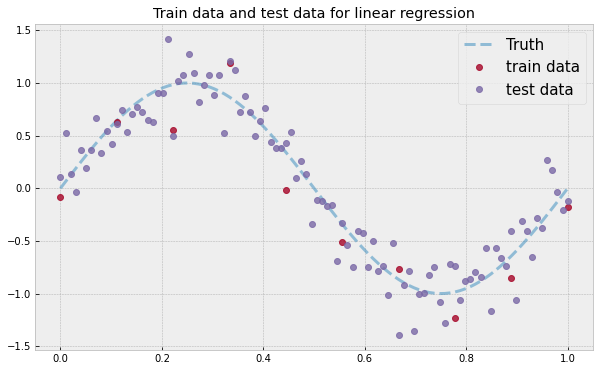

In [3]:
# 테스트에 쓸 데이터를 정의한 노트북 파일을 로드한다.
%run ./data.ipynb

In [4]:
print(x_train)
print(t_train)

[0.     0.1111 0.2222 0.3333 0.4444 0.5556 0.6667 0.7778 0.8889 1.    ]
[-0.0834  0.6315  0.5576  1.1941 -0.0167 -0.5104 -0.7654 -1.2339 -0.8544 -0.1818]


## 선형모델<sup>linear model</sup>

- 준비한 학습데이터를 잘 표현하는 직선을 찾고 싶다면 다음과 같은 직선을 생각해볼 수 있다.

$$
y = w_0 + w_1 x
$$

- 현재 문제에서 입력 $x$는 스칼라(숫자 하나), 결정해야하는 파라미터 $w_0$, $w_1$ 두개 

- 위 식에서 $w_0$뒤에 숫자 1이 곱해져있다고 생각해보면 다음처럼 쓸 수 있다.

$$
y = w_0 \times 1 + w_1 \times x
$$

- 위 식을 벡터 형식으로 써보면 다음과 같은데

$$
y = w_0 \times 1 + w_1 \times x =  (w_0, w_1) \cdot \begin{pmatrix} 1 \\ x\end{pmatrix}= \mathbf{w}^{\text{T}} \mathbf{x}
$$

- 주어진 문제에서 입력 $x$는 스칼라이지만 이때 $\mathbf{x}$는 첫번째 요소에 항상 1이 오는 요소 개수 2인 벡터가 된다.

- $x$를 입력되는 데이터의 특성이라고 본다면 우리는 1이라는 아무 의미없는 특성을 하나 추가하여 스칼라 데이터를 벡터 데이터로 확장한것으로 볼 수 도 있다.

- $w_0=1$, $w_1=-2$로 설정하고 주어진 데이터에 $\mathbf{w}$를 곱하여 타겟 $\boldsymbol{\mathsf{t}}$를 구하는 코드는 다음과 같다.

원래 x_train
[0.     0.1111 0.2222 0.3333 0.4444 0.5556 0.6667 0.7778 0.8889 1.    ]


첫 요소에 1을 추가하여 각각을 벡터로 만든 x_train : X
(10, 2)
[[1.     0.    ]
 [1.     0.1111]
 [1.     0.2222]
 [1.     0.3333]
 [1.     0.4444]
 [1.     0.5556]
 [1.     0.6667]
 [1.     0.7778]
 [1.     0.8889]
 [1.     1.    ]]


w와 X의 내적
[[ 1.    ]
 [ 0.7778]
 [ 0.5556]
 [ 0.3333]
 [ 0.1111]
 [-0.1111]
 [-0.3333]
 [-0.5556]
 [-0.7778]
 [-1.    ]]


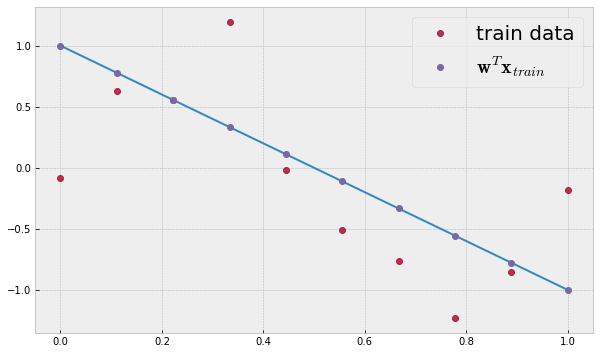

In [5]:
# x_train은 숫자 1개인 입력데이터 10개가 있는 1차원 데이터
print("원래 x_train")
print(x_train)
print('\n')

# 결정해야하는 두개의 w
w0 = 1.0
w1 = -2.
w = np.array([w0, w1])

# 첫번째 요소에 1을 추가하고
X = np.array([np.ones_like(x_train), x_train]).T
print("첫 요소에 1을 추가하여 각각을 벡터로 만든 x_train : X")
print(X.shape)
print(X)
print('\n')

#w와 내적을 하면 결과값 10개가 만들어 진다. w^t X
print("w와 X의 내적")
print(np.dot(X,w.reshape(-1,1)))

plt.figure(figsize=(10,6))
plt.plot(x, x*w[1]+w[0])
plt.plot(x_train, t_train, 'o', alpha=0.8, label="train data")
plt.plot(x_train, np.dot(X,w.reshape(-1,1)), 'o', label=r"$\mathbf{w}^T \mathbf{x}_{train}$")
plt.legend(fontsize=20)
plt.show()

- 보라색 포인트가 계산된 타겟값인데 맞추기를 원하는 붉은색 타겟과는 차이가 많이 나는 것을 확인할 수 있다.

### 다항식 기저

- 위 과정으로 부터 직선으로 데이터를 잘 표현할 수 있을것 같지 않다.

- 다음과 같은 곡선을 생각해보자

$$
y(x, \mathbf{w}) = w_0 x^0 + w_1 x^1 + w_2 x^2 + \cdots + w_M x^M = \sum_{j=0}^{M} w_j x^j
$$

- $M=1$이면 앞서 이야기한 직선과 동일

- 위 다항식은 $x$에 대해서 비선형, $w$에 대해서 선형($w$에 대해서 제곱이상의 항이 없음) 따라서 선형모델이라 한다.

- $w$에 대해 선형이란 의미는 `linearity.ipynb`을 보면 더 확실히 알 수 있다.

- 위 다항식이 $\sin(2\pi x)$와 비슷하기를 원하는 것이다.

- 다르게 말하면 "데이터를 발생시킨 곡선이 위 다항식과 비슷하지 않았을까?" 하고 가정하는 것

- 따라서 가끔 위 다항식 $y(x, \mathbf{w})$을 가설<sup>hypothesis</sup>로 부르기도 함. 즉 우리의 가설이 잘 맞기를 바라는 상황이다.

- 머신러닝의 특성<sup>feature</sup>관점에서 보면 주어진 데이터는 $x$인데 여기에 $x^0$, $x^2$, ... , $x^M$ 이라는 새로운 숫자들을 추가한 것이므로 회귀에 필요한 특성을 더 추가 해준것으로 볼 수 도 있다.

- 예를들어 주어진 데이터 $\mathcal{D}= (x, t)$이 주택 가격에 관련된 데이터인데 여기서 $x$는 주택의 너비를 의미하고 $t$는 주택의 가격이라면 $x$가 크면 클 수록 $t$가 커지는 관계를 가질 것이라 예상 가능

- 이 경우 $x^2$은 주택의 면적, $x^3$은 주택 공간의 부피로 주택에 대한 특성이라고 볼 수 있음.

- 항상 물리적 의미를 부여할 수 있는 것은 아니며 이 경우도 $x^4$이상이라면 물리적 의미를 부여하기는 힘들어 진다.

- 가설이 꼭 다항식일 필요는 없고, 실제로 다항식이 아닌 경우도 수업 마지막에 간단한 예제로 제시 되어 있다.

- 다항식 가설을 만들기 위해 주어진 $x$에 다항 함수를 적용하였는데 이때 적용한 각각의 다항함수를 다음처럼 표기하기로 하자.

$$
\phi_0(x) = x^0, \, \phi_{1}(x) = x^1, \phi_{2}(x)=x^2, \dots , \phi_{M}(x) = x^M
$$

- 위 표기법으로 가설을 다시 적어보자.

$$
y(x, \mathbf{w}) = w_0 \phi_0(x) + w_1 \phi_{1}(x) + w_2 \phi_{2}(x) + \cdots + w_M \phi_{M}(x) = \sum_{j=0}^{M} w_j \phi_{j}(x)
$$

- 다시적은 $y(x,\mathbf{w})$는 어떤 함수 $\phi_{j}(x)$ (여기서는 이 어떤 함수가 다항함수인 경우에 대해 이야기하고 있지만 앞서 언급했듯이 어떤 함수가 되어도 상관없다.)에 $w_j$를 곱하여 다 더한 함수가 된다.

- 따라서 $\phi_{j}(x)$는 $y(x,\mathbf{w})$를 만들기위한 재료가 되고 우리는 이것들을 $w_j$를 사용하여 잘 섞어서 결과로 나온 $y(x,\mathbf{w})$를 실제 타겟과 최대한 비슷하게 만들어야 하는 상황이 된다. 

- 때문에 $\phi_{j}(x)$를 기저함수<sup>basis function</sup>이라 한다.

- 주어진 데이터가 $D$차원 벡터이고 이에 대한 기저함수 형식으로 가설을 가장 일반적인 형태로 표현하면 다음과 같다.

$$
y(\mathbf{x},\mathbf{w}) = 
\begin{bmatrix}
w_0 & w_1 & w_2 & \cdots & w_M
\end{bmatrix}
\begin{bmatrix}
\phi_0(\mathbf{x}) \\[10pt]  \phi_1(\mathbf{x}) \\[10pt]  \phi_2(\mathbf{x}) \\[10pt]  \vdots \\[10pt]  \phi_M(\mathbf{x})
\end{bmatrix} =
\mathbf{w}^{\text{T}} \boldsymbol{\phi}(\mathbf{x})
$$

- 기저함수의 표현을 보면 벡터변수 $\mathbf{x}$를 입력받아서 스칼라 출력을 내보내는 함수라는 것을 알 수 있다. 

- 더 나아가 모든 기저함수를 모아서 벡터 형식으로 쓰면 벡터 변수를 입력받아서 벡터를 출력하는 다변수 벡터 함수로 볼 수 도 있다.

$$
\boldsymbol{\phi}(\mathbf{x})=\begin{bmatrix}
\phi_0(\mathbf{x}) \\[10pt]  \phi_1(\mathbf{x}) \\[10pt]  \phi_2(\mathbf{x}) \\[10pt]  \vdots \\[10pt]  \phi_M(\mathbf{x})
\end{bmatrix}
$$

- 이제 여기서 우리가 결정해야할 사항은 
    - 어떤 기저함수 형태를 사용할 것인가?
    - 항을 몇개까지 설정할까? 즉 기저함수의 결정과 $M$을 얼마로 선택하는가 하는것으로 가설 또는 모델의 복잡도를 결정한다. 이 $M$에 대한 결정은 선형회귀 문제를 푸는 것과 상관없이 임의로 결정해야하는 값이며 하이퍼 파라미터라고 한다.
    - $M+1$개의 $w$들은 어떻게 설정할까? 이 질문에 대한 답을 하는 것이 선형회귀 문제를 푸는 과정이 된다.
    
    
- 현재로써는 기저함수의 형태는 다항식으로 결정했고 $M$과 그에 따른 $\mathbf{w}$를 결정하는 구체적인 방법을 모르기 때문에 그냥 마음대로 결정하기로 하자.

- 편한대로 다음처럼 결정한다. $M=3$, $w_0 = -2$, $w_1 = 1.5$, $w_2 = 0.3$, $w_3 = 3$

$$
y(x, \mathbf{w}) = -2 + 1.5x + 0.3x^2 + 3 x^3
$$

- 아래 코드 결과를 보면 적당히 곡선성이 추가되었지만 여전히 잘 맞지 않고 있다.

w : -2, 1.5, 0.3, 3


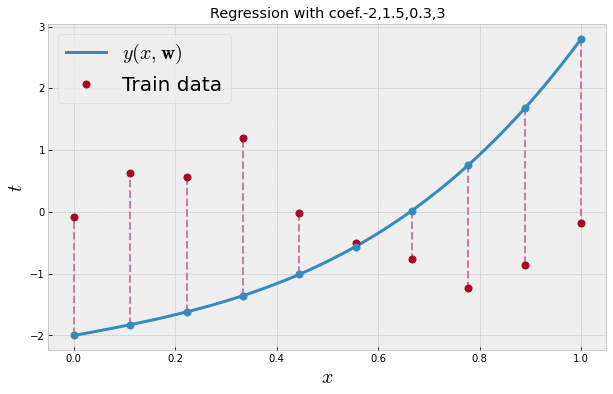

In [6]:
y = -2 + 1.5*x + 0.3*x**2 + 3*x**3
y_pred = -2 + 1.5*x_train + 0.3*x_train**2 + 3*x_train**3

print("w : {}, {}, {}, {}".format(-2, 1.5, 0.3, 3))

plt.figure(figsize=(10,6))
plt.plot([x_train, x_train],[y_pred, t_train], '--', color=style_colors[5], lw=2)
plt.plot(x, y, label="$y(x, \mathbf{w})$", lw=3)
plt.plot(x_train, t_train, 'o',  markersize=7 , label=r'Train data')
plt.plot(x_train, y_pred, 'o',  markersize=7, color=style_colors[0])
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$t$', fontsize=20)
plt.title('Regression with coef.{},{},{},{}'.format(-2, 1.5, 0.3, 3))
plt.legend(fontsize=20)

plt.show()

### numpy, sklearn을 이용한 선형회귀

- 구체적으로 직접 알고리즘을 만들어보기 전에 두 라이브러리로 선형회귀를 수행하여 결과를 비교 해보자.

- `numpy`에 최소제곱을 수행하는 간단한 `polyfit`함수 제공하고 `sklearn`에도 `LinearRegression`을 제공한다.

- 두 결과는 동일 : 수학적으로 같은 알고리즘

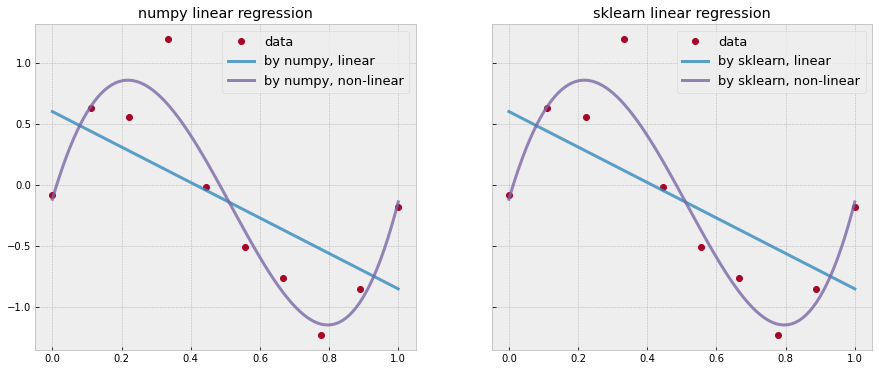

numpy coef.   : [  3.2748  14.1305 -27.1019   9.6745], Bias:-0.1181
sklearn coef. : [  3.2748  14.1305 -27.1019   9.6745], Bias:-0.1181


In [7]:
######################################################
# 본격적으로 회귀를 하기 전에 기존 라이브러리를 이용하여 
# 결과를 만들고 우리 알고리즘의 결과와 비교해보자.
######################################################
# M차 다항식
# w가 5차원 벡터, 각 4차 계수, 각 3차 계수, 2차 계수, 1차 계수, 0차 계수(상수) 
M = 4

#########################################################################
## 넘파이 라이브러리를 사용해서 간단하게 구할 수 있다.
#########################################################################
# 1차 다항식
z_lin    = np.polyfit(x_train, t_train, 1) 

# M차 다항식
z_nonlin = np.polyfit(x_train, t_train, M)

y_lin    = np.poly1d(z_lin)
y_nonlin = np.poly1d(z_nonlin)
#########################################################################

#########################################################################
## sklearn 라이브러리를 사용해서 간단(?)하게 구할 수 있다.
#########################################################################
# 1차 다항식
model = LinearRegression(fit_intercept=True)
model.fit(x_train[:, np.newaxis], t_train)
y_sk_lin = model.predict(x[:, np.newaxis])

# M차 다항식
poly_model = make_pipeline(PolynomialFeatures(M), LinearRegression())
poly_model.fit(x_train[:, np.newaxis], t_train)
y_sk_nonlin = poly_model.predict(x[:, np.newaxis])

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches((15,6))

ax1.plot(x_train, t_train, 'o', color=style_colors[1], label=r"data")
ax1.plot(x, y_lin(x), linewidth=3, alpha=0.8, color=style_colors[0], label=r"by numpy, linear")
ax1.plot(x, y_nonlin(x), linewidth=3, alpha=0.8, color=style_colors[2], label=r"by numpy, non-linear")
ax1.legend(fontsize=13)
ax1.set_title('numpy linear regression')

ax2.plot(x_train, t_train, 'o', color=style_colors[1], label=r"data")
ax2.plot(x, y_sk_lin, linewidth=3, alpha=0.8, color=style_colors[0], label=r"by sklearn, linear")
ax2.plot(x, y_sk_nonlin, linewidth=3, alpha=0.8, color=style_colors[2], label=r"by sklearn, non-linear")
ax2.legend(fontsize=13)
ax2.set_title('sklearn linear regression')

plt.show()

print("numpy coef.   : {}, Bias:{:.4f}".format(z_nonlin[:-1], z_nonlin[-1]))
print("sklearn coef. : {}, Bias:{:.4f}".format(poly_model.steps[-1][1].coef_[::-1][:-1], 
                                      poly_model.steps[-1][1].intercept_))


- 이제 배운 지식을 무기로 `numpy`, `sklearn` 알고리즘 직접 만들어보자!


- 문제를 풀기 위해 적절한 오차함수를 구성하고 이를 최소화 시키는 $\mathbf{w}$를 찾기 위해 다음과 같은 두가지 방법을 고려하기로 한다.
    - #### 경사 하강법
    - #### 정규 방정식 풀이

## 경사하강을 이용한 선형회귀

- 위처럼 마음대로 정하는 것이 문제해결에 도움을 주지는 않지만 문제 해결 방향을 잡을 수 있게 해준다.

- 시간이 무한대로 주어진다면 적절히 $\mathbf{w}$를 조정하면서 함수값이 최소 근처가 되도록 조정할 수 있다.

- 우리도 linreg.html 파일을 통해 같은 작업을 해본적이 있지만 결정해야하는 $\mathbf{w}$의 요소 개수가 많아지면 힘들어진다.

- 문제를 제대로 해결하기 위해 다음과 같은 에러 함수를 정의

$$
E(\mathbf{w}) = \frac{1}{2} \sum_{n=1}^{N} \{ y(x_n, \mathbf{w}) - t_n \}^2 
$$

$$
E(\mathbf{w}) = \frac{1}{2N} \sum_{n=1}^{N} \{ y(x_n, \mathbf{w}) - t_n \}^2 
$$


- $x_n$, $t_n$는 변수가 아니고 우리가 가지고 있는 점 데이터

- 여기서 변수는 계수 $w_0, w_1, \dots, w_M $, $M+1$개

- 우리의 가설이 타겟과 최대한 비슷하기를 바라는데 가설과 타겟의 차이는 $ y(x_n, \mathbf{w}) - t_n$ 부분이다.

- 따라서 위 함수는 우리의 가설과 타겟값의 차이를 제곱해서 모두 더한 값을 계산해주는 함수이다.

- 조금전 우리 마음대로 정한 계수값에 대해서 에러 값 계산해보자.


In [8]:
######################################################
# 우리 마음대로 정한 변수w를 이용하여 오차를 계산
######################################################
y = -2 + 1.5*x_train + 0.3*x_train**2 + 3*x_train**3

print(0.5*(((y - t_train)**2).sum()))

20.917214052454877


- 꽤 큰값이 계산되는데 이 값을 최대한 0으로 만드는 것이 우리의 목적이 된다.

- 위처럼 오차의 제곱을 최소화시키기를 원하기 때문에 최소제곱법<sup>least square</sup>이라는 이름으로 불린다.

### 경사하강법

- 위처럼 에러 함수가 정의되었으면 최적화 수법을 에러 함수 $E(\mathbf{w})$에 적용해서 문제를 해결할 수 있다.

- 즉, 정의한 에러함수가 최적화의 목적함수가 되고 목적함수를 정의한 이후의 과정은 최적화 과정과 동일하다.

#### 에러 함수

- 다음과 같은 에러 함수를 계산하는 코드

$$
E(\mathbf{w}) = \frac{1}{2} \sum_{n=1}^{N} \{ y(x_n, \mathbf{w}) - t_n \}^2 
$$


In [9]:
def E(w, M, x, t):
    """
    Error function
    E(w)= (1/2) * sum_{n=1}^{N} {y(x_n,w) - t_n}^2
    y(x_n, w) = w_0*x^0 + w_1*x^1 + w_2*x^2 + ... + w_M*x^M
    """
    X = np.array([ x**i for i in range(M+1) ])  
    y = (w.reshape(-1,1) * X).sum(axis=0)
    
    return 0.5*(( (y - t)**2 ).sum())

In [10]:
x_train

array([0.    , 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889, 1.    ])

In [11]:
print(M)
X = np.array([ x_train**i for i in range(M+1) ])  
print(X)

w = np.random.rand(M+1)
print(w)
print((w.reshape(-1,1) * X).sum(axis=0))

# sum 없이 하려면?
print(np.dot(X.T, w))

4
[[1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00]
 [0.0000e+00 1.1111e-01 2.2222e-01 3.3333e-01 4.4444e-01 5.5556e-01 6.6667e-01 7.7778e-01 8.8889e-01 1.0000e+00]
 [0.0000e+00 1.2346e-02 4.9383e-02 1.1111e-01 1.9753e-01 3.0864e-01 4.4444e-01 6.0494e-01 7.9012e-01 1.0000e+00]
 [0.0000e+00 1.3717e-03 1.0974e-02 3.7037e-02 8.7791e-02 1.7147e-01 2.9630e-01 4.7051e-01 7.0233e-01 1.0000e+00]
 [0.0000e+00 1.5242e-04 2.4387e-03 1.2346e-02 3.9018e-02 9.5260e-02 1.9753e-01 3.6595e-01 6.2430e-01 1.0000e+00]]
[0.1106 0.2741 0.0103 0.6294 0.2952]
[0.1106 0.1421 0.1796 0.23   0.3012 0.402  0.5426 0.7341 0.9886 1.3194]
[0.1106 0.1421 0.1796 0.23   0.3012 0.402  0.5426 0.7341 0.9886 1.3194]


#### 에러함수의 경사도벡터

- 수치미분 코드를 사용 하거나 또는 직접 미분하여 다음처럼 함수를 만들어 사용할 수도 있음

- 자세한 미분 과정은  정규방정식 유도에서 다시 이야기 함

$$
\begin{aligned}
\frac{\partial E(\mathbf{w})}{\partial \, \mathbf{w}} 
&=   \sum_{n=1}^{N} \left( \mathbf{w}^{\text{T}} \boldsymbol{\phi}(\mathbf{x}_n) \,   - t_n \right) \boldsymbol{\phi}(\mathbf{x}_n)^{\text{T}} \\[15pt]
&= \mathbf{w}^{\text{T}} \left( \sum_{n=1}^{N}  \boldsymbol{\phi}(\mathbf{x}_n) \, \boldsymbol{\phi}(\mathbf{x}_n)^{\text{T}} \right) - \sum_{n=1}^{N}  t_n \boldsymbol{\phi}(\mathbf{x}_n)^{\text{T}} \\[15pt]
&= \mathbf{w}^{\text{T}} \left( \mathbf{\Phi}^{\text{T}} \mathbf{\Phi} \right) -\boldsymbol{\mathsf{t}}^{\text{T}} \mathbf{\Phi}
\end{aligned}
$$

- 위 식은 스칼라를 벡터로 미분할 때 분자 레이아웃을 써서 결과 벡터가 행벡터임을 유의해야 함.

In [12]:
def grad_anal(w, M, x, t):
    """
    This function computes the analytic gradient of the objective function
    x, t : data for error function eval.
    """
    N = x.shape[0]
    PI = np.hstack( np.array( [np.power(x.reshape(N,1), p) for p in range(M+1)] ) )
    
    # 위 식을 그대로 코딩
    # g_  = np.dot(w.T, np.dot(PI.T, PI) ) - np.dot(t.T, PI)
    
    # 식을 정리해서 np.dot 2번으로...
    g = np.dot( np.dot(w.T,PI.T)-t.T , PI)
    
    # print(g)
    # print(g.shape)
    # print(g_)
    # print(g_.shape)
    
    return g.astype('longdouble') 

In [13]:
from scipy import optimize

In [14]:
np.random.seed(0)

# 혹시 아래쪽에서 E함수를 레귤러라이제이션 항이 있는 버전으로 덮어썼을 가능성이 있기 때문에
# 여기서 다시 레귤러라이제이션 항을 없애준다.
regularizer = ''

# M을 0, 1, 3, 8에 대해서 한번씩 피팅
ms = [0, 1, 3, 8]

# 피팅결과 구해진 파라미터를 W에 저장
W = []

# 학습데이터를 넘기면서 fitting
for M in ms :
    x0 = np.random.uniform(-1, 1, M+1)
    
    ############################################################################
    # 우리가 만든 minimize함수를 사용하는 경우
#     W.append(minimize(E, x0, args=(M, x_train, t_train), 
#                       jac=grad_anal, method="CGFR", verbose_step=500))   
    ############################################################################
    
    ############################################################################
    # scipy.optimize.minimize 사용하는 경우
    ret = optimize.minimize(E, x0,  args=(M, x_train, t_train), 
                            jac=grad_anal, method='BFGS', 
                            options={'gtol': 1e-08,})
    W.append(ret.x)
    print(ret)
    ############################################################################
    
    print('\n')

      fun: 2.5575776291401144
 hess_inv: array([[1]])
      jac: array([1.1657e-15], dtype=float64)
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([-0.1263], dtype=float64)


      fun: 1.4841548409949135
 hess_inv: array([[ 0.3449, -0.4892],
       [-0.4892,  0.9766]], dtype=float64)
      jac: array([-8.9107e-10, -9.5873e-10], dtype=float64)
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 7
     njev: 8
   status: 0
  success: True
        x: array([ 0.5996, -1.4518], dtype=float64)


      fun: 0.2402224072984602
 hess_inv: array([[   0.7973,   -5.543 ,   10.696 ,   -6.07  ],
       [  -5.543 ,   67.7942, -157.8902,   97.866 ],
       [  10.696 , -157.8902,  394.5959, -254.198 ],
       [  -6.07  ,   97.866 , -254.198 ,  167.8186]], dtype=float64)
      jac: array([ 6.5638e-09,  1.2574e-09, -2.9665e-09, -5.3736e-09], dtype=float64)
  message: 'Optimization terminated s

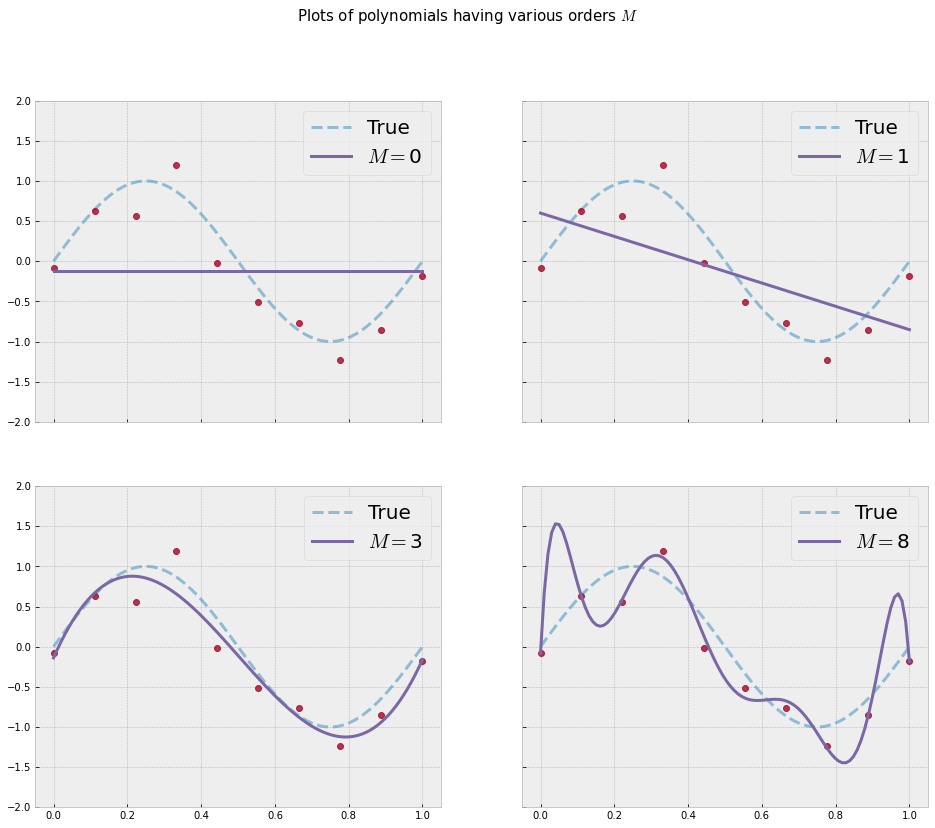

M=0       M=1        M=3            M=8
0 -0.12627  0.599645  -0.139682      -0.082299
1      NaN -1.451831  10.483091      90.751711
2      NaN       NaN -31.185369   -1698.272058
3      NaN       NaN  20.680189   12647.995512
4      NaN       NaN        NaN  -47354.721824
5      NaN       NaN        NaN   97608.618543
6      NaN       NaN        NaN -112611.383684
7      NaN       NaN        NaN   68191.475090
8      NaN       NaN        NaN  -16874.563844

In [15]:
import pandas as pd
from IPython.display import display

fig, ax = plt.subplots(2, 2, sharex='all', sharey='all')
fig.set_size_inches((16,13))

j = 0
ax[0,0].set_ylim(-2,2)

for M in ms :
    p, q = divmod(j, 2)
    X = np.array([ x**i for i in range(M+1) ])  
    y = (W[j].reshape(-1,1) * X).sum(axis=0)

    ax[p,q].plot(x, t, '--', lw=3, alpha=0.5, label="True")
    ax[p,q].plot(x_train, t_train, 'o', alpha=0.8)
    ax[p,q].plot(x, y, lw=3, label="$M=${}".format(M))
    ax[p,q].legend(loc='upper right', fontsize=20)

    j+=1

plt.suptitle('Plots of polynomials having various orders $M$', fontsize=15)
plt.show()

# 회귀계수를 모아서 테이블 형태로 출력
A = np.full((9, 4), np.nan)
for i in range(len(W)) :
    A[0:W[i].shape[0], i] = W[i]

df = pd.DataFrame(data=A,  columns=['M=0', 'M=1', 'M=3', 'M=8'])
display(df)  # OR print(df.to_html()) or display(HTML(df.to_html()))    

#### 평가하기

$$
E_{\text{RMS}} = \sqrt{\frac{2 E(\mathbf{w}^{*})}{N}}
$$

- 오차함수값에 루트를 씌워 데이터와 동일한 스케일을 가지도록 하고(오차함수에 이미 제곱이 되어있기 때문)

- $N$으로 나누어 평균적인 오차를 알아볼 수 있게 함.

- 2 곱하기는 오차함수에 (1/2)이 곱해져 있기 때문

In [16]:
def rms(w, E, M, x, t) :
    return np.sqrt( (2*E(w, M, x, t)) / x.shape[0] )

## 에러 평가

In [17]:
np.random.seed(0)

# M을 0~(M_overfit-1)에 대해서 한번씩 피팅
M_overfit = 9
Ms = np.arange(M_overfit)

# 피팅결과 구해진 파라미터를 W에 저장
W = []

# 학습데이터를 넘기면서 fitting
for M in Ms :
    x0 = np.random.uniform(-1, 1, M+1)
    
    ############################################################################
    # 우리가 만든 minimize함수를 사용하는 경우
    # W.append(minimize(E, x0, args=(M, x_train, t_train), 
    #                   jac=grad_anal, method="CGFR", verbose_step=500))  
    ############################################################################
    
    ############################################################################
    # scipy.optimize.minimize 사용하는 경우
    ret = optimize.minimize(E, x0,  args=(M, x_train, t_train), 
                            jac=grad_anal, method='BFGS', 
                            options={'gtol': 1e-08,})
    print(ret)
    W.append(ret.x)
    ############################################################################
    
    print('\n')

      fun: 2.5575776291401144
 hess_inv: array([[1]])
      jac: array([1.1657e-15], dtype=float64)
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([-0.1263], dtype=float64)


      fun: 1.4841548409949135
 hess_inv: array([[ 0.3449, -0.4892],
       [-0.4892,  0.9766]], dtype=float64)
      jac: array([-8.9107e-10, -9.5873e-10], dtype=float64)
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 7
     njev: 8
   status: 0
  success: True
        x: array([ 0.5996, -1.4518], dtype=float64)


      fun: 1.4830582408356143
 hess_inv: array([[  0.6168,  -2.3353,   1.8485],
       [ -2.3353,  13.3995, -12.4078],
       [  1.8485, -12.4078,  12.3861]], dtype=float64)
      jac: array([ 1.9524e-09, -6.3906e-10, -1.1642e-09], dtype=float64)
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 13
     njev: 15
   status: 0
  success: True
        x: array([ 0.57

In [18]:
# 회귀계수를 모아서 테이블 형태로 출력
A = np.full((len(Ms), len(Ms)), np.nan)
for i in range(len(W)) :
    A[0:W[i].shape[0], i] = W[i]
    
df = pd.DataFrame(data=A,  columns=['M={}'.format(i) for i in range(len(Ms))])
display(df)  # OR print(df.to_html()) or display(HTML(df.to_html()))    

M=0       M=1       M=2        M=3        M=4         M=5         M=6  \
0 -0.12627  0.599645  0.575188  -0.139682  -0.118120   -0.071224   -0.063584   
1      NaN -1.451831 -1.286746  10.483091   9.674486    5.402322    3.363430   
2      NaN       NaN -0.165085 -31.185369 -27.101916    8.509224   33.663572   
3      NaN       NaN       NaN  20.680190  14.130492  -86.530330 -194.797002   
4      NaN       NaN       NaN        NaN   3.274849  118.654943  327.877673   
5      NaN       NaN       NaN        NaN        NaN  -46.152038 -232.259311   
6      NaN       NaN       NaN        NaN        NaN         NaN   62.035757   
7      NaN       NaN       NaN        NaN        NaN         NaN         NaN   
8      NaN       NaN       NaN        NaN        NaN         NaN         NaN   

           M=7            M=8  
0    -0.071246      -0.082299  
1    11.649602      90.751702  
2  -103.064756   -1698.271890  
3   616.017606   12647.994271  
4 -1964.750122  -47354.717200  
5  3111.060231   97608.608990  
6 -2364.232667 -112611.372612  
7   693.219550   68191.468357  
8          NaN  -16874.562173

- 1차에서 9차까지 회귀 결과에 대해 학습, 테스트 데이터로 각각 RMS를 계산

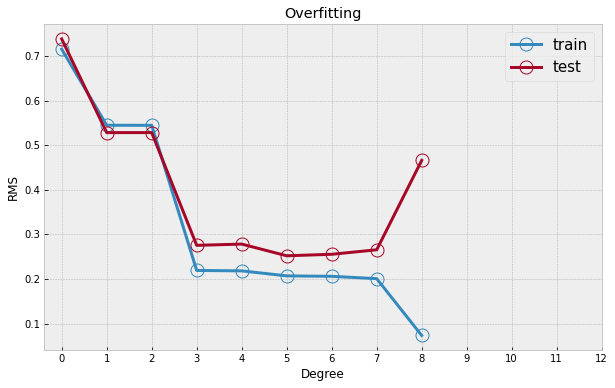

In [19]:
RMS = np.zeros((len(Ms), 3))

for i in Ms :
    RMS[i, 0] = i
    RMS[i, 1] =rms(W[i], E, W[i].shape[0]-1, x_train, t_train)
    
for i in Ms :
    RMS[i, 2] =  rms(W[i], E, W[i].shape[0]-1, x_test, t_test)

plt.figure(figsize=(10,6))
plt.plot(RMS[:,0], RMS[:,1], 'o-', lw=3, markersize=13, fillstyle='none',  label='train')    
plt.plot(RMS[:,0], RMS[:,2], 'o-', lw=3, markersize=13, fillstyle='none', label='test')
plt.title('Overfitting')
plt.xticks( np.arange(13))

plt.xlabel('Degree')
plt.ylabel('RMS')

plt.legend(fontsize=15)
plt.show()

### 과적합<sup>Over-ftting</sup>

- 훈련 데이터에 잘 맞으나 그외의 데이터에 잘 맞지 않는 상태

- 위 그래프에서 다항식의 차수가 7차를 넘어가는 순간 과적합 발생

#### 더 많은 데이터를 모아서 해결

- 더 많은 데이터가 문제를 해결 할 수 있는지 실험

In [20]:
###########################################
# 8차로 더 많은 데이터를 모아 선형회귀 시도
###########################################
M = 8

x0 = np.random.uniform(-1, 1, M+1)

############################################################################
# 우리가 만든 minimize함수를 사용하는 경우
# w = minimize(E, x0, args=(M, x_test, t_test), 
#              jac=grad_anal, method="CGFR", verbose_step=500)
############################################################################

############################################################################
# scipy.optimize.minimize 사용하는 경우
ret = optimize.minimize(E, x0,  args=(M, x_test, t_test), 
                            jac=grad_anal, method='BFGS', 
                            options={'gtol': 1e-08,})
print(ret)
w = ret.x
############################################################################

      fun: 1.9781997807481435
 hess_inv: array([[ 5.3951e-01, -2.1426e+01,  2.7292e+02, -1.6253e+03,  5.2448e+03, -9.7262e+03,  1.0357e+04, -5.8844e+03,  1.3817e+03],
       [-2.1426e+01,  1.2702e+03, -1.8896e+04,  1.2240e+05, -4.1649e+05,  8.0106e+05, -8.7610e+05,  5.0798e+05, -1.2121e+05],
       [ 2.7292e+02, -1.8896e+04,  3.0322e+05, -2.0573e+06,  7.2243e+06, -1.4216e+07,  1.5820e+07, -9.2986e+06,  2.2433e+06],
       [-1.6253e+03,  1.2240e+05, -2.0573e+06,  1.4395e+07, -5.1680e+07,  1.0342e+08, -1.1660e+08,  6.9267e+07, -1.6857e+07],
       [ 5.2448e+03, -4.1649e+05,  7.2243e+06, -5.1680e+07,  1.8865e+08, -3.8245e+08,  4.3575e+08, -2.6109e+08,  6.3999e+07],
       [-9.7262e+03,  8.0106e+05, -1.4216e+07,  1.0342e+08, -3.8245e+08,  7.8344e+08, -9.0031e+08,  5.4330e+08, -1.3399e+08],
       [ 1.0357e+04, -8.7610e+05,  1.5820e+07, -1.1660e+08,  4.3575e+08, -9.0031e+08,  1.0420e+09, -6.3265e+08,  1.5684e+08],
       [-5.8844e+03,  5.0798e+05, -9.2986e+06,  6.9267e+07, -2.6109e+08,  5.4

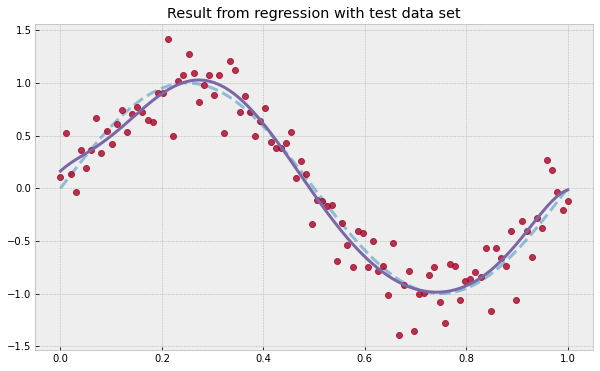

W:[ 1.6331e-01  4.4979e+00 -4.3286e+01  5.1822e+02 -2.5092e+03  5.6695e+03 -6.6766e+03  4.0158e+03 -9.7905e+02]


In [21]:
###########################################
# 많은 데이터에 대한 회귀결과 출력
###########################################
X = np.array([ x**i for i in range(M+1) ])  
y = (w.reshape(-1,1) * X).sum(axis=0)

plt.figure(figsize=(10,6))
plt.plot(x, t, '--', lw=3, alpha=0.5)
plt.plot(x_test, t_test, 'o', alpha=0.8)
plt.plot(x, y, lw=3)
plt.title("Result from regression with test data set")
plt.show()

print("W:{}".format(w.reshape(1,-1)[::-1][0].astype('float64')))

#### 레귤러라이제이션<sup>regularization</sup>를 통한 해결

- 현실적으로 데이터를 많이 모을 수 없음

- 우선 다음과 같은 항을 에러함수에 추가

$$
\tilde{E}(\mathbf{w}) = \frac{1}{2} \sum_{n=1}^{N} \left\{ y(x_n, \mathbf{w}) - t_n \right\}^2 + \color{OrangeRed}{\frac{\lambda}{2} \lVert \mathbf{w} \rVert^2}
$$

- 직관적 해석 : 에러함수에 $\mathbf{w}$의 요소가 제곱되어 다 더해진 항이 추가 되면서 $w_j$가 커지면 에러값이 커지게 설계

- 절편항에 대한 회귀 계수 $w_0$는 레귤러라이제이션에서 제외하는 경우도 있음(sklearn은 이런식으로 구현됨)

 
    

In [22]:
###########################################
# L2 Reg. term을 가진 에러함수를 다시 정의하고 피팅 시도
###########################################
def E_L2(w, M, x, t):
    """
    Error function with L2 Reg. term
    """
    X = np.array([ x**i for i in range(M+1) ])  
    y = (w.reshape(-1,1) * X).sum(axis=0)
    
    #                                                L2 reg. term
    return 0.5*(( (y - t)**2 ).sum()) + (lamda/2.) * np.linalg.norm(w[1:])**2

M = 8
lamda = np.exp(-10)
x0 = np.random.uniform(-1, 1, M+1)

############################################################################
# 우리가 만든 minimize함수를 사용하는 경우
# w = minimize(E_L2, x0, args=(M, x_test, t_test, lamda), 
#              method="CGFR", verbose_step=500)
############################################################################

############################################################################
# scipy.optimize.minimize 사용하는 경우
ret = optimize.minimize(E_L2, x0,  args=(M, x_train, t_train), method='BFGS', )
print(ret)
w = ret.x
############################################################################

      fun: 0.23290454148446182
 hess_inv: array([[ 8.1993e-01, -7.5325e+00,  1.9644e+01, -1.3424e+01, -7.5883e+00,  3.4834e+00,  5.8692e+00,  2.8754e+00, -4.1583e+00],
       [-7.5325e+00,  1.6691e+02, -6.7150e+02,  7.4330e+02,  1.7607e+02, -3.4672e+02, -2.4352e+02, -2.4059e+01,  2.0695e+02],
       [ 1.9644e+01, -6.7150e+02,  3.3382e+03, -4.6328e+03, -2.4934e+02,  2.5994e+03,  9.0565e+02, -4.8621e+02, -8.2363e+02],
       [-1.3424e+01,  7.4330e+02, -4.6328e+03,  8.3459e+03, -1.7250e+03, -5.5826e+03,  5.6726e+02,  2.7943e+03, -4.9354e+02],
       [-7.5883e+00,  1.7607e+02, -2.4934e+02, -1.7250e+03,  2.9833e+03,  2.0558e+03, -3.2493e+03, -3.0961e+03,  3.1118e+03],
       [ 3.4834e+00, -3.4672e+02,  2.5994e+03, -5.5826e+03,  2.0558e+03,  4.0908e+03, -1.3450e+03, -2.6914e+03,  1.2126e+03],
       [ 5.8692e+00, -2.4352e+02,  9.0565e+02,  5.6726e+02, -3.2493e+03, -1.3450e+03,  4.0460e+03,  3.3013e+03, -3.9916e+03],
       [ 2.8754e+00, -2.4059e+01, -4.8621e+02,  2.7943e+03, -3.0961e+03, -2.

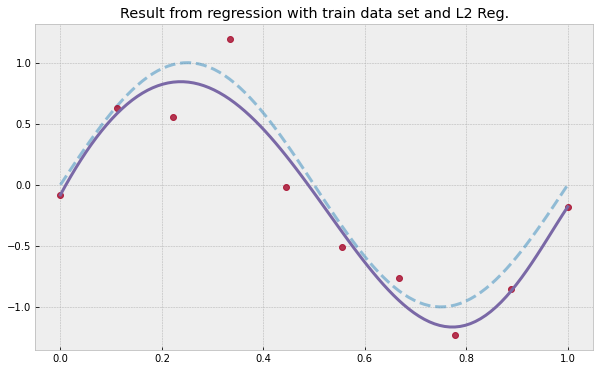

W:[ -0.0818   7.706  -14.9814  -6.38     5.8452   9.1076   5.3745  -0.6789  -6.0915]


In [23]:
###########################################
# L2 레귤러라이제이션 결과 출력
###########################################
X = np.array([ x**i for i in range(M+1) ])  
y = (w.reshape(-1,1) * X).sum(axis=0)

plt.figure(figsize=(10,6))
plt.plot(x, t, '--', lw=3, alpha=0.5)
plt.plot(x_train, t_train, 'o', alpha=0.8)
plt.plot(x, y, lw=3)
plt.title("Result from regression with train data set and L2 Reg.")
plt.show()

print("W:{}".format(w.reshape(1,-1)[::-1][0]))

- 레귤러라이제이션 사용 결과 : 많은 데이터를 모으지 않고도 9차 다항식으로 괜찮은 결과 생성

- 주로 사용되는 레귤러라이제이션 : L1, L2 레귤러라이제이션

- 아래는 L1, L2 노름의 형상화

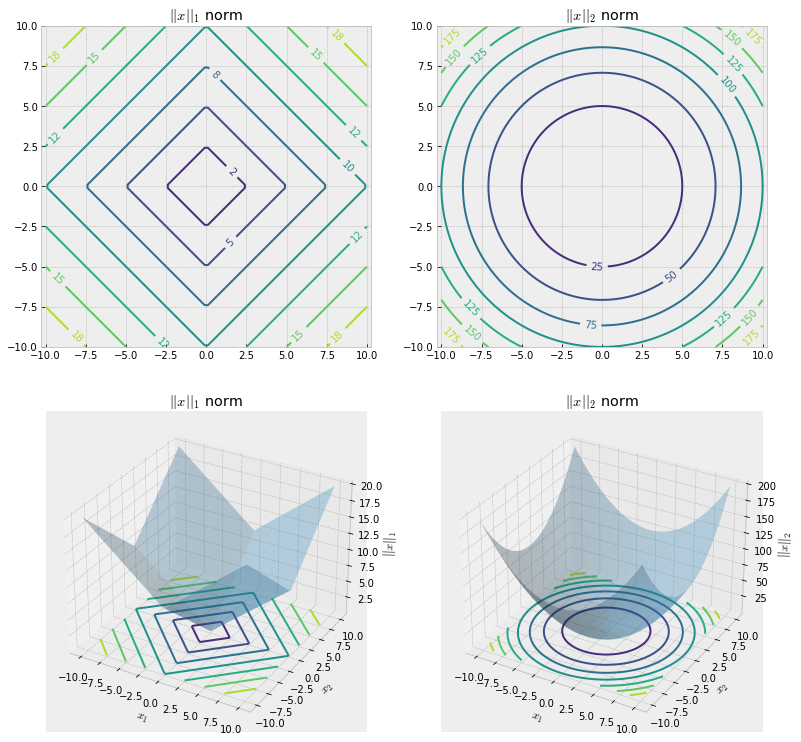

In [24]:
w = np.linspace(-10,10,100)
W1, W2 = np.meshgrid(w, w)

#L2
L2 = W1**2 + W2**2

#L1 
L1 = np.abs(W1) + np.abs(W2)

fig = plt.figure()
fig.set_size_inches((13,13))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax4 = fig.add_subplot(2, 2, 4, projection='3d')

CS = ax1.contour(W1, W2, L1)
ax1.clabel(CS, CS.levels,  fmt='%1.0f', inline=True, fontsize=10)
ax1.axis('equal')
ax1.set_title(r'$||x||_{1}$ norm')

CS = ax2.contour(W1, W2, L2)
ax2.clabel(CS, CS.levels,  fmt='%1.0f', inline=True, fontsize=10)
ax2.axis('equal')
ax2.set_title(r'$||x||_{2}$ norm')

ax3.plot_surface(W1, W2, L1, rstride=5, cstride=5, alpha=0.3)
cset = ax3.contour(W1, W2, L1, zdir='z', offset=0, cmap='viridis')
ax3.set_xlabel(r'$x_1$')
ax3.set_ylabel(r'$x_2$')
ax3.set_zlabel(r'$||x||_{1}$')
ax3.set_title(r'$||x||_{1}$ norm')

ax4.plot_surface(W1, W2, L2, rstride=5, cstride=5, alpha=0.3)
cset = ax4.contour(W1, W2, L2, zdir='z', offset=0, cmap='viridis')
ax4.set_xlabel(r'$x_1$')
ax4.set_ylabel(r'$x_2$')
ax4.set_zlabel(r'$||x||_{2}$')
ax4.set_title(r'$||x||_{2}$ norm')

plt.show()

### L1, L2 레귤러라이제이션 실험

- 아래는 L1, L2 레귤러라이제이션의 실험코드

- 에러 함수안에 lamda를 변화시켜가면서 제약조건과 최적해거 어떻게 결정되는지 확인

- L1 레귤러라이제이션항이 추가된 목적함수는 미분 불가능한 점이 생김

- L1 레귤러라이제이션의 경우 $w_j=0$인 지점에서 미분계수 0을 사용

- 이를 위해 L1항이 추가된 목적함수는 수치 미분하지 않고 직접 미분한 함수를 사용<sup>[3],[4],[5]</sup> 


In [25]:
#
# L1, L2 Reg.의 효과를 비교하기 위한 프로그램
#

def E_reg(w, M, x, t):
    """
    Error function with L1 or L2 Reg. term
    Calculate differently according to global variable; regularizer and reg_intercept
    """
    N = x.shape[0]
    
    X = np.array([ x**i for i in range(M+1) ])  
    y = (w.reshape(-1,1) * X).sum(axis=0)
    
    if regularizer == 'L2' :
        # L2 reg.
        if not reg_intercept :
            return 0.5*(( (y - t)**2 ).sum()) + (lamda/2.)*np.linalg.norm(w[1:])**2 
        else :
            return 0.5*(( (y - t)**2 ).sum()) + (lamda/2.)*np.linalg.norm(w)**2   
    elif regularizer == 'L1' :
        # L1 reg.
        if not reg_intercept :
            return 0.5*(( (y - t)**2 ).sum()) + (lamda/2.)*(np.abs(w[1:]).sum()) 
        else :
            return 0.5*(( (y - t)**2 ).sum()) + (lamda/2.)*(np.abs(w).sum())   
    else :
        return 0.5*(( (y - t)**2 ).sum())
       
def grad_L1(w, M, x, t):
    """
    This function computes the analytic gradient of the objective function with L1 reg. term
    x, t : data for error function eval.
    """
    # 다항함수를 기반으로하는 design matrix Φ를 만든다.
    PI = np.hstack( np.array([np.power(x.reshape(N,1), p) for p in range(M+1)]) )
    g = np.dot(w.T, np.dot(PI.T, PI) ) - np.dot(t.T, PI)
    
    if not reg_intercept :
        g_reg = np.hstack( np.array([0 , (lamda/2.)*np.sign(w[1:])]) ) 
    else :
        g_reg = (lamda/2.)*np.sign(w)       
        
    g += g_reg
    
    return g

In [26]:
###############################################################
# 전역변수 설정

# 직선으로 회귀, 여기서는 바꾸면 안됨, w의 그림을 그리기 위해. 2개 이상되면 그림 못 그림
M = 1          

# 레귤러라이제이션 상수이자 동시에 제약조건에 할당된 라그랑지승수
lamda = None         

# L1 or L2 레귤러라이제이션 선택, L1, L2바꿔가면서 실험해볼 수 있음
regularizer = 'L2' 

# 레귤러라이제이션에서 절편항을 포함시킬지 말지를 결정
reg_intercept = True
################################################################

# 여기서 람다를 바꿔가면서 여러번 fit
if regularizer == 'L1' :
    lambdas = np.linspace(0, 3, 30)
else :
    lambdas = np.linspace(0, 15, 40)
    
ws = np.zeros((len(lambdas), M+1))
x0 = np.random.uniform(-1, 1, M+1)

for i, lamda in enumerate(lambdas) :
    if regularizer == 'L1' :
        ############################################################################
        # 우리가 만든 minimize함수를 사용하는 경우
        # w = minimize(E_reg, x0, args=(M, x_train, t_train), 
        #              jac=grad_L1, strict=False, max_iter=1500, verbose=False)
        ############################################################################
        
        ############################################################################
        # scipy.optimize.minimize 사용하는 경우
        ret = optimize.minimize(E_reg, x0,  args=(M, x_train, t_train), 
                                jac=grad_L1, method='SLSQP',)
        w = ret.x
        ############################################################################
        
    else :
        ############################################################################
        # 우리가 만든 minimize함수를 사용하는 경우
        # w = minimize(E, x0, args=(M, x_train, t_train), max_iter=1500, verbose=False)
        ############################################################################
                
        ############################################################################
        # scipy.optimize.minimize 사용하는 경우
        ret = optimize.minimize(E_reg, x0,  args=(M, x_train, t_train), 
                                method='SLSQP', )
        w = ret.x
        ############################################################################
        
    ws[i,:] = w
    print("lambda:{:f}, w:{}".format(lamda, w))
    print()

lambda:0.000000, w:[ 0.5996 -1.4519]

lambda:0.384615, w:[ 0.362  -1.0042]

lambda:0.769231, w:[ 0.2426 -0.7751]

lambda:1.153846, w:[ 0.1715 -0.6351]

lambda:1.538462, w:[ 0.1249 -0.5407]

lambda:1.923077, w:[ 0.0923 -0.4725]

lambda:2.307692, w:[ 0.0684 -0.4208]

lambda:2.692308, w:[ 0.0503 -0.3802]

lambda:3.076923, w:[ 0.0363 -0.3474]

lambda:3.461538, w:[ 0.0252 -0.3203]

lambda:3.846154, w:[ 0.0163 -0.2975]

lambda:4.230769, w:[ 0.0091 -0.278 ]

lambda:4.615385, w:[ 0.003  -0.2612]

lambda:5.000000, w:[-0.002  -0.2465]

lambda:5.384615, w:[-0.0062 -0.2335]

lambda:5.769231, w:[-0.0097 -0.222 ]

lambda:6.153846, w:[-0.0127 -0.2116]

lambda:6.538462, w:[-0.0152 -0.2023]

lambda:6.923077, w:[-0.0174 -0.1938]

lambda:7.307692, w:[-0.0192 -0.186 ]

lambda:7.692308, w:[-0.0208 -0.1789]

lambda:8.076923, w:[-0.0222 -0.1724]

lambda:8.461538, w:[-0.0233 -0.1664]

lambda:8.846154, w:[-0.0243 -0.1608]

lambda:9.230769, w:[-0.0253 -0.1555]

lambda:9.615385, w:[-0.0259 -0.1508]

lambda:10.00

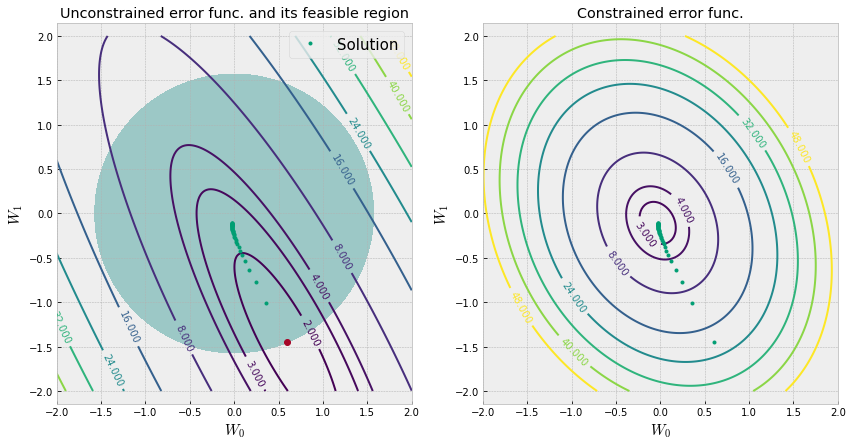

In [27]:
######################################################
# 2개의 파라미터로 회귀한 결과를 출력
# 파라미터가 2개라서 에러함수는 2변수 실함수가 되고 등고선 플롯으로 그릴 수 있다.
# 비제약 최적해와 제약조건산에 결정된 최적해 비교
######################################################

# 회귀계수 공간에서 메쉬그리드 만들기
ww = np.linspace(-2, 2, 200)
W1, W2 = np.meshgrid(ww, ww)
W = np.array([W1, W2])

# 앞선 9차까지 순차적으로 계샌해둔 결과중에서 직선회귀 결과를 이용해서
# 무제약 최적해를 초기화
w_unconst =  np.array(A[0:2,1])

#############################################################
# 제약조건 함수
L2 = W1**2 + W2**2 #L2
L1 = np.abs(W1) + np.abs(W2) #L1 
L = {'L1':L1, 'L2':L2}
#############################################################

#############################################################
# 제약조건에 나타나는 eta 계산 eq(1.4)
eta_L1 = np.abs(ws[0,:]).sum()
eta_L2 = (ws[0,:]**2).sum()
eta = {'L1':eta_L1, 'L2':eta_L2}
#############################################################

#############################################################
# 에러함수의 제약조건 있는 상태와 없는 상태를 계산
# 루프 돌리면 구현은 직관적이나 비효율적
E_unconst = np.zeros_like(W1)
E_const = np.zeros_like(W1)

for i in range(W1.shape[0]) :
    for j in range(W1.shape[1]) :
        E_unconst[i,j] = E(W[:,i,j], M, x_train, t_train) 
        E_const[i,j]   = E_reg(W[:,i,j], M, x_train, t_train) 
#############################################################

fig = plt.figure()
fig.set_size_inches((14,7))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# 여기서 바로 애니메이션으로 만들기
from matplotlib import animation, rc
from IPython.display import HTML


##################################################################################
# ax1
# 무제약 에러함수 그림
CS1 = ax1.contour(W1, W2, E_unconst,  levels=[2, 3, 4, 8, 16, 24, 32, 40, 48])
ax1.clabel(CS1, CS1.levels,  fmt='%.3f', inline=True, fontsize=10)

# 제약 최적해와 무제약 최적해를 그림
# 유용 영역 그림
CS1_cst = ax1.contourf(W1, W2, L[regularizer], levels=[0, eta[regularizer]], alpha=0.4)
sol1, = ax1.plot(ws[:,0], ws[:,1], '.', color=style_colors[7], label='Solution')
ax1.plot(*w_unconst, 'o', color=style_colors[1])
ax1.set_xlabel('$W_0$', fontsize=15)
ax1.set_ylabel('$W_1$', fontsize=15)
ax1.legend(fontsize=15)
ax1.set_title('Unconstrained error func. and its feasible region')
ax1.axis('equal')

##################################################################################
# ax2
# 제약 에러함수 그림
CS2 = ax2.contour(W1, W2, E_const, levels=[2, 3, 4, 8, 16, 24, 32, 40, 48])
ax2.clabel(CS2, CS2.levels,  fmt='%.3f', inline=True, fontsize=10)

# 제약 최적해
sol2, = ax2.plot(ws[:,0], ws[:,1], '.', color=style_colors[7], label='Solution')
ax2.set_xlabel('$W_0$', fontsize=15)
ax2.set_ylabel('$W_1$', fontsize=15)
ax2.set_title('Constrained error func.')
ax2.axis('equal');


def update(i):
    global CS1_cst, CS2, lamda
    
    # 유용역역 업데이트
    #############################################################
    # 제약조건에 나타나는 eta 계산 eq(1.4)
    eta_L1 = np.abs(ws[i,:]).sum()
    eta_L2 = (ws[i,:]**2).sum()
    eta = {'L1':eta_L1, 'L2':eta_L2}
    
    for c in CS1_cst.collections:
        c.remove()  # removes only the contours, leaves the rest intact
    CS1_cst = ax1.contourf(W1, W2, L[regularizer], levels=[0, eta[regularizer]], alpha=0.4)
    
    #############################################################
    # 제약조건 추가된 에러함수 업데이트
    lamda = lambdas[i]
    for j in range(W1.shape[0]) :
        for k in range(W1.shape[1]) :
            E_const[j,k]   = E(W[:,j,k], M, x_train, t_train) 
            
    for c in CS2.collections:
        c.remove()  # removes only the contours, leaves the rest intact
    CS2 = ax2.contour(W1, W2, E_const, levels=[2, 3, 4, 8, 16, 24, 32, 40, 48])

    #솔루션 업데이트
    sol1.set_data(ws[i,0], ws[i,1])
    sol2.set_data(ws[i,0], ws[i,1])

    
# 이 부분은 시간이 많이 걸리기 때문에 필요할때만 주석을 제거하여 실행해야함    
# ani = animation.FuncAnimation(fig, update, frames=np.arange(ws.shape[0]), interval=100)
# rc('animation', html='html5')
# HTML(ani.to_html5_video())

# gif로 출력하려면 다음 라인 사용한다. imagemagick 라이브러리가 설치되어 있어야 함.
# ani.save('L2.gif', dpi=80, writer='imagemagick')

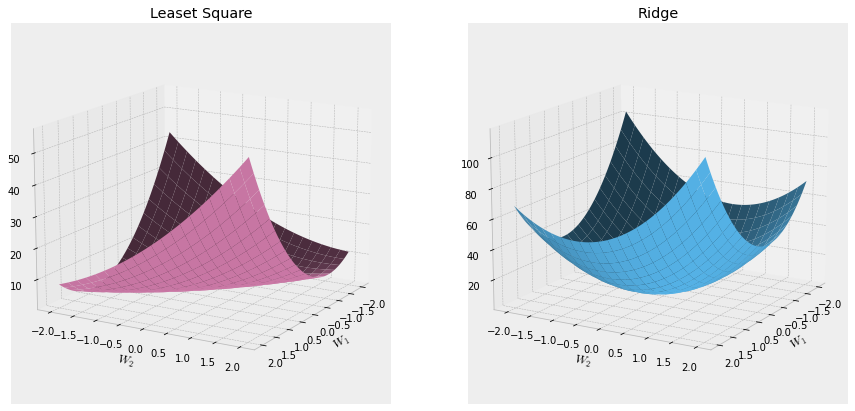

In [28]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.plot_surface(W1, W2, E_unconst, rstride=10, color=style_colors[5],  cstride=10, alpha=1)
ax1.view_init(15, 30)
ax1.set_xlabel('$W_1$')
ax1.set_ylabel('$W_2$')
ax1.set_title("Leaset Square")

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot_surface(W1, W2, E_const, rstride=10,  color=style_colors[6], cstride=10,  alpha=1)
ax2.view_init(15, 30)
ax2.set_xlabel('$W_1$')
ax2.set_ylabel('$W_2$')

if regularizer == 'L1' :
    ax2.set_title("Lasso")
else:
    ax2.set_title("Ridge")

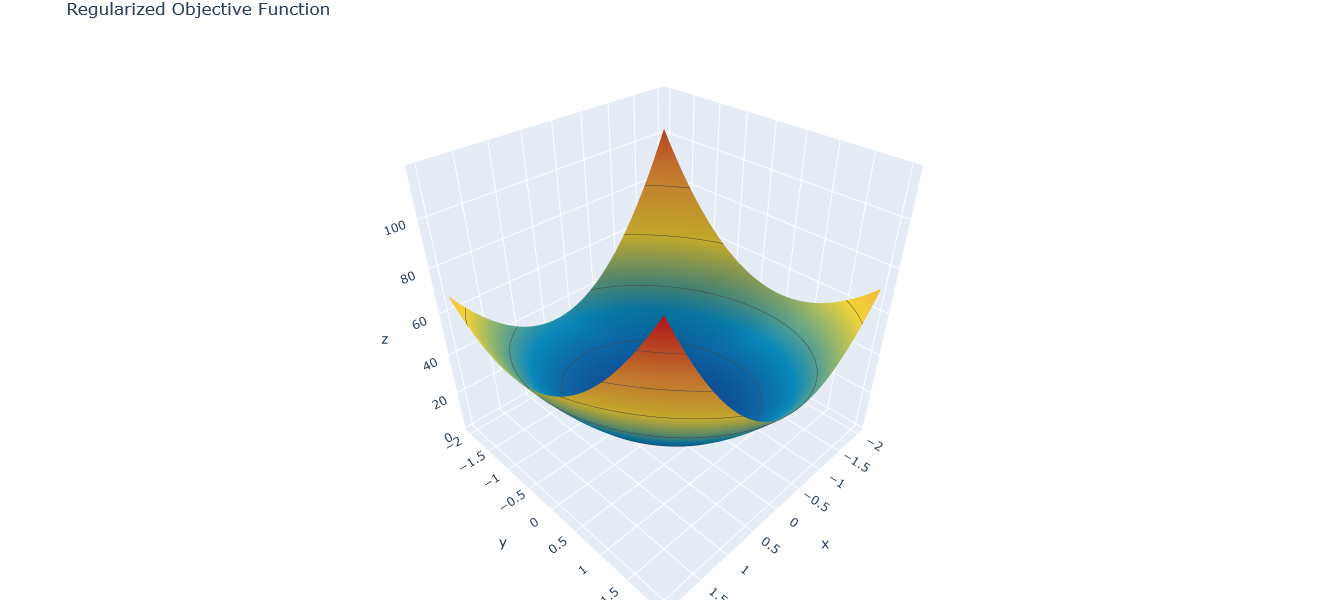

In [29]:
# https://plot.ly/python/
# https://plot.ly/python/offline/

# hover contour off
# https://community.plot.ly/t/trace-lines-appearing-on-hover/5801
data = [
    go.Surface(x=W1, y=W2, z=E_const, showscale=False, colorscale='Portland',
               contours=dict(
                   x=dict(show=False,  highlight=False),
                   y=dict(show=False,  highlight=False),
                   z=dict(show=True,  highlight=True, highlightcolor="#A60628"),
               ),
    ),
]

layout = go.Layout(
    title='Regularized Objective Function',
    autosize=False, 
    width=600, height=600,
    margin=dict(l=0, r=0, b=0, t=30)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## 참고문헌

1. [Bishop] Pattern Recognition and Machine Learning, Christopher Bishop, Springer

3. [why-ridge] https://stats.stackexchange.com/questions/118712/why-does-ridge-estimate-become-better-than-ols-by-adding-a-constant-to-the-diago/119708#119708

4. [오일석] 기계학습, 오일석, 한빛미디어

5. [Geron] Hands-On Machine Learning(핸즈온 머신러닝), Aurelien Geron(박해선 역), O'Reilly(한빛미디어)

6. [subgradient-wiki] https://en.wikipedia.org/wiki/Subgradient_method


In [30]:
from IPython.core.display import HTML

def _set_css_style(css_file_path):
   """
   Read the custom CSS file and load it into Jupyter.
   Pass the file path to the CSS file.
   """
   styles = open(css_file_path, "r").read()
   s = '<style>%s</style>' % styles     
   return HTML(s)

_set_css_style("../../style.css")